## CPPI Article #1

#### Imports

In [1]:
import sys, os
import datetime as dt

In [11]:
from multiprocessing import Pool

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Add the project dir
sys.path.append(os.path.abspath('../'))
from src.core import *

In [4]:
# Add the paths generation classes
sys.path.append(os.path.abspath('../paths/'))
from paths import *

In [5]:
from src.cppi.strategy import CppiStrategy

In [6]:
# Reload classes on-the-fly
# to take into account modifications
%load_ext autoreload
%autoreload 2

### Generate some Monte Carlo paths

<Axes: >

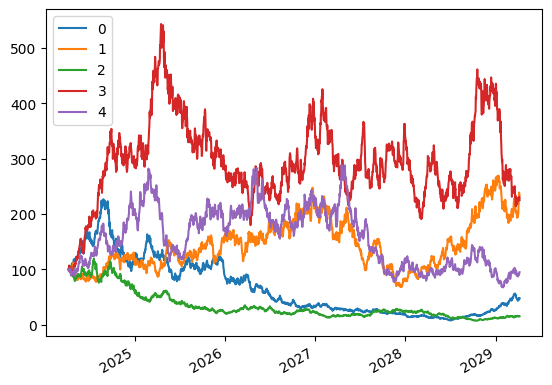

In [7]:
mc_paths = 10

maturity = 5.0
time_intervals = maturity * 365

gbm = GeometricBrownianMotion(volatility=0.60, 
                              drift=0.20, 
                              initial_value=100.0, 
                              maturity=maturity, 
                              time_intervals=time_intervals,
                              seed=40)
gbm.generate(mc_paths)
df_paths = gbm.to_datetime_index()

df_paths.iloc[:, 0:5].plot()

### One core assumption is that vol and drift are common to all paths... but what if they'#re not. One can make the case for vol, but what about drift? Can we plan for various states of the world at once?? 

### Create a CPPI Simulation

In [8]:
# Select a path
#
# sample = 0  # goes down a lot
sample = 1  # goes up a lot

# Construct a historical data feed
#
feed = MonteCarloDataFeed(df_paths, columns=[sample, ])

# This is the object that provides analysis of the results 
#
analytics = AnalyticsEngine()

# Set up a CPPI strategy and wrap it into the execution agent
#
cppi = CppiStrategy(floor=0.80,
                    initial_value=100000.0, 
                    reset_freq=dt.timedelta(days=100))

exec_cppi = ExecutionEngine(cppi)

# The context provides the support for backtesting
#
backtest = ContextualEngine(data=feed,
                           agent=exec_cppi,
                           analytics=analytics)

# Start the backtest
backtest.start()

Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9B396A80>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B375B20>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9B2F8860>
Backtest ended successfully.


In [9]:
analytics = AnalyticsEngine()

for i in range(df_paths.shape[1]):
    
    feed_i = MonteCarloDataFeed(df_paths, columns=[i, ])
    cppi = CppiStrategy(floor=0.80,
                    initial_value=100000.0, 
                    reset_freq=dt.timedelta(days=100))

    agent_cppi_i = ExecutionEngine(cppi)
    
    backtest_i = ContextualEngine(data=feed_i,
                           agent=agent_cppi_i,
                           analytics=analytics)

    # Start the backtest
    # backtest_i.start()

Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9D581700>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B395880>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9B394D70>
Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9D56FAA0>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B395880>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9D56FF80>
Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9B394D70>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B395880>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9D56C110>
Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9D56FF80>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B395880>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9D56FA10>
Initializing

In [16]:
from src.core.context.engine import start_bt

In [19]:
bts = []

for i in range(df_paths.shape[1]):
    
    df_i = pd.DataFrame(df_paths.iloc[:, i], index=df_paths.index, columns=[i, ])
    
    feed_i = MonteCarloDataFeed(df_paths, columns=[i, ])
    
    cppi = CppiStrategy(floor=0.80,
                        initial_value=100000.0,
                        reset_freq=dt.timedelta(days=100))

    agent_cppi_i = ExecutionEngine(cppi)

    backtest_i = ContextualEngine(data=feed_i,
                                  agent=agent_cppi_i,
                                  analytics=analytics)
    bts.append(backtest_i)


Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9D697830>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B395880>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9D6821E0>
Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9D5A2480>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B395880>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9D56C0B0>
Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9D736270>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B395880>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9B4D9AF0>
Initializing <src.core.execution.ExecutionEngine object at 0x0000028A9D736E70>
Initializing <src.core.analytics.AnalyticsEngine object at 0x0000028A9B395880>
Initializing <src.core.feed.monte_carlo.MonteCarloDataFeed object at 0x0000028A9D737620>
Initializing

In [20]:
bts[0].start()

Backtest ended successfully.


In [21]:
pool = Pool(processes=6)
pool.map(start_bt, bts)

PicklingError: Can't pickle <class 'src.core.context.engine.ContextualEngine'>: it's not the same object as src.core.context.engine.ContextualEngine

In [ ]:
analytics.realizations

In [ ]:
results = analytics.realizations[5]
df_results = analytics.summarize(results)
df_results.plot()

In [ ]:
df_results.head(20)

In [ ]:
total_return_pa = (df_results.iloc[-1, :] / df_results.iloc[0, :] - 1.0).apply(np.log) / maturity
total_return_pa

In [ ]:
total_vol_pa = (df_results / df_results.shift(1) - 1.0).std() * np.sqrt(time_intervals/maturity)
total_vol_pa

In [ ]:
total_return_pa / total_vol_pa

In [ ]:
import statsmodels.tsa.arima_process as arma

In [ ]:
samples = 365 * 24
np.random.seed(50)
df_arma = pd.DataFrame(arma.arma_generate_sample(1, 8, samples))

vol = 0.5
mat = 1.0
dt_ = mat / samples
sigma_dW = vol * dt_ * df_arma

pd.DataFrame(np.cumprod(np.exp(sigma_dW))).plot()

In [ ]:
df_arma.hist(bins=50)

In [ ]:
df_arma.describe()